In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
dfraw = pd.read_csv('dfraw.csv')

In [3]:
dfraw.head()

,Amount given Credit,Gender,Education,Marital Status,Age,Repayment Sep,Repayment Aug,Repayment Jul,Repayment Jun,Repayment May,...,Amount Prev Pay Jul,Amount Prev Pay Jun,Amount Prev Pay May,Amount Prev Pay Apr,Default Payment,Total Bill,Total Pay,Count Late,Mean Pay Late,Debt
0,20000,2,2,1,24,2,2,0,0,0,...,0,0,0,0,1,7704,689,2,0.666667,7015
1,120000,2,2,2,26,0,2,0,0,0,...,1000,1000,0,2000,1,17077,5000,2,0.666667,12077
2,90000,2,2,2,34,0,0,0,0,0,...,1000,1000,1000,5000,0,101653,11018,0,0.000000,90635
3,50000,2,2,1,37,0,0,0,0,0,...,1200,1100,1069,1000,0,231334,8388,0,0.000000,222946
4,50000,1,2,1,57,0,0,0,0,0,...,10000,9000,689,679,0,109339,59049,0,0.000000,50290


In [4]:
df = dfraw.copy()

## Feature Engineering

### Binning

In [5]:
df.Age = pd.cut(df.Age,[0,25,40,65,100], labels=('Young','Adult','Old','Elder'))
df.head()

,Amount given Credit,Gender,Education,Marital Status,Age,Repayment Sep,Repayment Aug,Repayment Jul,Repayment Jun,Repayment May,...,Amount Prev Pay Jul,Amount Prev Pay Jun,Amount Prev Pay May,Amount Prev Pay Apr,Default Payment,Total Bill,Total Pay,Count Late,Mean Pay Late,Debt
0,20000,2,2,1,Young,2,2,0,0,0,...,0,0,0,0,1,7704,689,2,0.666667,7015
1,120000,2,2,2,Adult,0,2,0,0,0,...,1000,1000,0,2000,1,17077,5000,2,0.666667,12077
2,90000,2,2,2,Adult,0,0,0,0,0,...,1000,1000,1000,5000,0,101653,11018,0,0.000000,90635
3,50000,2,2,1,Adult,0,0,0,0,0,...,1200,1100,1069,1000,0,231334,8388,0,0.000000,222946
4,50000,1,2,1,Old,0,0,0,0,0,...,10000,9000,689,679,0,109339,59049,0,0.000000,50290


In [6]:
df['Education'].value_counts()

2    14030
1    10585
3     4917
4      468
Name: Education, dtype: int64

In [7]:
num = ['Amount given Credit', 'Repayment Sep', 'Repayment Aug',
       'Repayment Jul', 'Repayment Jun', 'Repayment May', 'Repayment Apr',
       'Amount of Bill Sep', 'Amount of Bill Aug', 'Amount of Bill Jul',
       'Amount of Bill Jun', 'Amount of Bill May', 'Amount of Bill Apr',
       'Amount Prev Pay Sep', 'Amount Prev Pay Aug', 'Amount Prev Pay Jul',
       'Amount Prev Pay Jun', 'Amount Prev Pay May', 'Amount Prev Pay Apr',
       'Total Bill','Total Pay','Count Late','Mean Pay Late','Debt']

num1 = ['Amount given Credit','Age','Repayment Sep', 'Repayment Aug',
       'Repayment Jul', 'Repayment Jun', 'Repayment May', 'Repayment Apr',
       'Amount of Bill Sep', 'Amount of Bill Aug', 'Amount of Bill Jul',
       'Amount of Bill Jun', 'Amount of Bill May', 'Amount of Bill Apr',
       'Amount Prev Pay Sep', 'Amount Prev Pay Aug', 'Amount Prev Pay Jul',
       'Amount Prev Pay Jun', 'Amount Prev Pay May', 'Amount Prev Pay Apr',
       'Total Bill','Total Pay','Count Late','Mean Pay Late','Debt']

cat = ['Education','Marital Status','Age']
cat1 = ['Education','Marital Status']

In [8]:
df['Education'].value_counts()

2    14030
1    10585
3     4917
4      468
Name: Education, dtype: int64

In [9]:
df.describe(exclude=np.number)

,Age
count,30000
unique,4
top,Adult
freq,17855


## Dataset Splitting

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Amount given Credit  30000 non-null  int64   
 1   Gender               30000 non-null  int64   
 2   Education            30000 non-null  int64   
 3   Marital Status       30000 non-null  int64   
 4   Age                  30000 non-null  category
 5   Repayment Sep        30000 non-null  int64   
 6   Repayment Aug        30000 non-null  int64   
 7   Repayment Jul        30000 non-null  int64   
 8   Repayment Jun        30000 non-null  int64   
 9   Repayment May        30000 non-null  int64   
 10  Repayment Apr        30000 non-null  int64   
 11  Amount of Bill Sep   30000 non-null  int64   
 12  Amount of Bill Aug   30000 non-null  int64   
 13  Amount of Bill Jul   30000 non-null  int64   
 14  Amount of Bill Jun   30000 non-null  int64   
 15  Amount of Bill May 

In [11]:
df['Education'].value_counts()

2    14030
1    10585
3     4917
4      468
Name: Education, dtype: int64

In [12]:
X = df.drop(columns='Default Payment')
y = df['Default Payment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24000, 28), (6000, 28), (24000,), (6000,))

## Menggunakan KNN

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.2min finished


{'algo__n_neighbors': 39, 'algo__p': 1.7965429868602332, 'algo__weights': 'uniform'}
0.7947880732136451 0.7549642641368355 0.7498453896109236
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.65      0.34      0.45      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.64      0.67      6000
weighted avg       0.79      0.81      0.79      6000



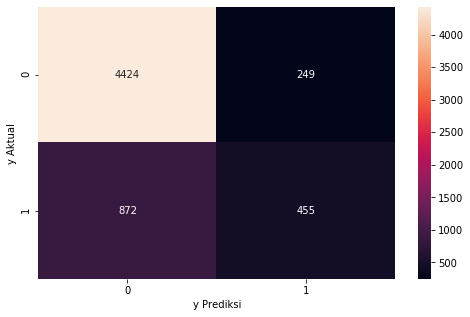

In [13]:
preprocessorknn = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), num),
    ('categoric', cat_pipe(encoder='onehot'), cat)
])

pipelineknn = Pipeline([
    ('prep', preprocessorknn),
    ('algo', KNeighborsClassifier(metric='euclidean'))
])

model1 = RandomizedSearchCV(pipelineknn, rsp.knn_params, cv=4,scoring='roc_auc', n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model1.fit(X_train, y_train)

print(model1.best_params_)
print(model1.score(X_train, y_train), model1.best_score_, model1.score(X_test, y_test))

print(classification_report(y_test,model1.predict(X_test)))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, model1.predict(X_test)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Prediksi")
plt.ylabel("y Aktual")
plt.show()

## Using Logistic Regression

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.7s finished


{'algo__C': 0.17670169402947963, 'algo__fit_intercept': True}
0.7630220597757833 0.760409746222037 0.7424261873473147
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4673
           1       0.66      0.33      0.44      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.64      0.66      6000
weighted avg       0.79      0.81      0.79      6000



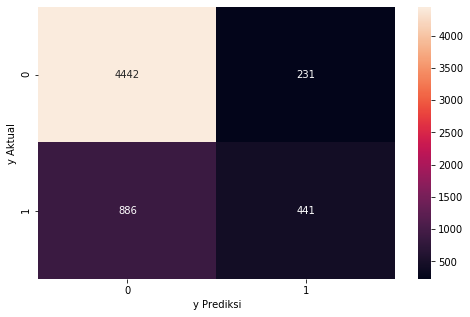

In [14]:
preprocessorlogreg = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), num),
    ('categoric', cat_pipe(encoder='onehot'), cat)
])

from sklearn.linear_model import LogisticRegression
pipelinelogreg = Pipeline([
    ('prep', preprocessorlogreg),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model2 = RandomizedSearchCV(pipelinelogreg, rsp.logreg_params,scoring='roc_auc' ,cv=4, n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model2.fit(X_train, y_train)

print(model2.best_params_)
print(model2.score(X_train, y_train), model2.best_score_, model2.score(X_test, y_test))

print(classification_report(y_test,model2.predict(X_test)))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, model2.predict(X_test)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Prediksi")
plt.ylabel("y Aktual")
plt.show()

## Using Random Forest Classifier

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.7min finished


{'algo__max_depth': 80, 'algo__max_features': 0.6371651421518384, 'algo__min_samples_leaf': 19, 'algo__n_estimators': 186}
0.9091719302606892 0.7794715565835275 0.771729835055912
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.37      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000



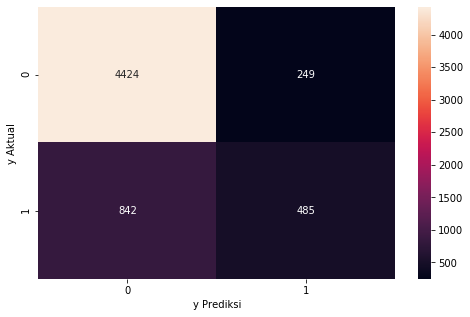

In [15]:
preprocessorrf = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), num),
    ('categoric', cat_pipe(encoder='onehot'), cat)
])

from sklearn.ensemble import RandomForestClassifier
pipelinerf = Pipeline([
    ('prep', preprocessorrf),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model3 = RandomizedSearchCV(pipelinerf, rsp.rf_params, cv=4,scoring='roc_auc', n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model3.fit(X_train, y_train)

print(model3.best_params_)
print(model3.score(X_train, y_train), model3.best_score_, model3.score(X_test, y_test))

print(classification_report(y_test,model3.predict(X_test)))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, model3.predict(X_test)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Prediksi")
plt.ylabel("y Aktual")
plt.show()

## Using SVC

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   15.4s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 0.17670169402947963, 'algo__gamma': 506.1576888752313}
0.588739186177188 0.5223988181339518 0.5402487731554759
              precision    recall  f1-score   support

           0       0.83      0.20      0.33      4673
           1       0.23      0.86      0.37      1327

    accuracy                           0.35      6000
   macro avg       0.53      0.53      0.35      6000
weighted avg       0.70      0.35      0.33      6000



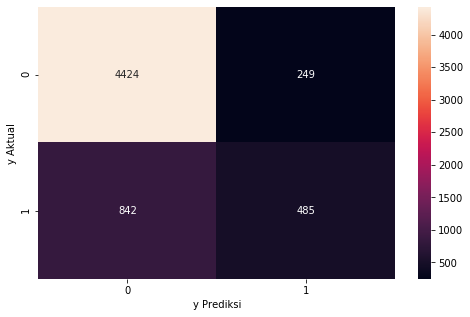

In [16]:
preprocessorsvc = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), num),
    ('categoric', cat_pipe(encoder='onehot'), cat)
])

from sklearn.svm import SVC
pipelinesvc = Pipeline([
    ('prep', preprocessorsvc),
    ('algo', SVC(max_iter=500))
])

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model4 = RandomizedSearchCV(pipelinesvc, rsp.svm_params, cv=4,scoring='roc_auc', n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model4.fit(X_train, y_train)

print(model4.best_params_)
print(model4.score(X_train, y_train), model4.best_score_, model4.score(X_test, y_test))

print(classification_report(y_test,model4.predict(X_test)))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, model3.predict(X_test)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Prediksi")
plt.ylabel("y Aktual")
plt.show()

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

f1_scoreKNN = f1_score(y_test, model1.predict(X_test))
f1_scoreLR = f1_score(y_test, model2.predict(X_test))
f1_scoreRF = f1_score(y_test, model3.predict(X_test))
f1_scoreSVC = f1_score(y_test, model4.predict(X_test))

precision_scoreKNN = precision_score(y_test, model1.predict(X_test))
precision_scoreLR = precision_score(y_test, model2.predict(X_test))
precision_scoreRF = precision_score(y_test, model3.predict(X_test))
precision_scoreSVC = precision_score(y_test, model4.predict(X_test))


recall_scoreKNN = recall_score(y_test, model1.predict(X_test))
recall_scoreLR = recall_score(y_test, model2.predict(X_test))
recall_scoreRF = recall_score(y_test, model3.predict(X_test))
recall_scoreSVC = recall_score(y_test, model4.predict(X_test))


accuracy_scoreKNN = accuracy_score(y_test, model1.predict(X_test))
accuracy_scoreLR = accuracy_score(y_test, model2.predict(X_test))
accuracy_scoreRF = accuracy_score(y_test, model3.predict(X_test))
accuracy_scoreSVC = accuracy_score(y_test, model4.predict(X_test))

model_scoreKNN = model1.score(X_test, y_test)
model_scoreLR = model2.score(X_test, y_test)
model_scoreRF = model3.score(X_test, y_test)
model_scoreSVC = model4.score(X_test, y_test)


scores = {'Model': ['KNearestNeighbors', 'Logistic Regression', 'Random Forest', 'SVC'],
          'Model Score' : [model_scoreKNN, model_scoreLR, model_scoreRF, model_scoreSVC],
          'Precision Score': [precision_scoreKNN, precision_scoreLR, precision_scoreRF, precision_scoreSVC],
         'Recall Score' : [recall_scoreKNN, recall_scoreLR, recall_scoreRF, recall_scoreSVC],
          'f1 Score' : [f1_scoreKNN, f1_scoreLR, f1_scoreRF, f1_scoreSVC],
         'Accuracy Score' : [accuracy_scoreKNN, accuracy_scoreLR, accuracy_scoreRF, accuracy_scoreSVC]}

model_compare = pd.DataFrame(scores, columns=['Model', 'Model Score', 'Precision Score', 'Recall Score', 'f1 Score', 'Accuracy Score'])
model_compare

,Model,Model Score,Precision Score,Recall Score,f1 Score,Accuracy Score
0,KNearestNeighbors,0.749845,0.646307,0.342879,0.448055,0.813167
1,Logistic Regression,0.742426,0.656250,0.332329,0.441221,0.813833
2,Random Forest,0.771730,0.660763,0.365486,0.470645,0.818167
3,SVC,0.540249,0.234086,0.859081,0.367920,0.347167


## Coba Smote untuk Handling Imbalance Target

In [18]:
from imblearn.over_sampling import SMOTE

X1 = dfraw.drop(columns='Default Payment')
y1 = dfraw['Default Payment']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2,stratify=y, random_state=42)
print(X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape)

print("Before OverSampling, counts of label '1': {}".format(sum(y1_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y1_train == 0))) 
  
# import SMOTE module from imblearn library 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X1_train, y1_train) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 

(24000, 28) (6000, 28) (24000,) (6000,)
Before OverSampling, counts of label '1': 5309
Before OverSampling, counts of label '0': 18691 

After OverSampling, the shape of train_X: (37382, 28)
After OverSampling, the shape of train_y: (37382,) 

After OverSampling, counts of label '1': 18691
After OverSampling, counts of label '0': 18691


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.2min finished


{'algo__max_depth': 22, 'algo__max_features': 0.1185260448662222, 'algo__min_samples_leaf': 2, 'algo__n_estimators': 187}
0.9975617016966262 0.92267903388128 0.7594216386169421
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4673
           1       0.54      0.50      0.52      1327

    accuracy                           0.80      6000
   macro avg       0.70      0.69      0.69      6000
weighted avg       0.79      0.80      0.79      6000



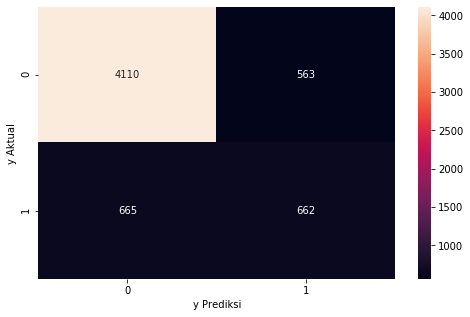

In [19]:
preprocessorrf = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), num1),
    ('categoric', cat_pipe(encoder='onehot'), cat1)
])

from sklearn.ensemble import RandomForestClassifier
pipelinerf = Pipeline([
    ('prep', preprocessorrf),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model5 = RandomizedSearchCV(pipelinerf, rsp.rf_params, cv=4,scoring='roc_auc', n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model5.fit(X_train_res, y_train_res)

print(model5.best_params_)
print(model5.score(X_train_res, y_train_res), model5.best_score_, model5.score(X1_test, y1_test))

print(classification_report(y1_test,model5.predict(X1_test)))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y1_test, model5.predict(X1_test)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Prediksi")
plt.ylabel("y Aktual")
plt.show()

Setelah di SMOTE, nilai recall positive naik, tapi recall negative turun

In [20]:
print("Before Undersampling, counts of label '1': {}".format(sum(y1_train == 1))) 
print("Before Undersampling, counts of label '0': {} \n".format(sum(y1_train == 0))) 
  
# apply near miss 
from imblearn.under_sampling import NearMiss 
nr = NearMiss() 
  
X_train_miss, y_train_miss = nr.fit_sample(X1_train, y1_train.ravel()) 
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape)) 
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape)) 
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0))) 


Before Undersampling, counts of label '1': 5309
Before Undersampling, counts of label '0': 18691 

After Undersampling, the shape of train_X: (10618, 28)
After Undersampling, the shape of train_y: (10618,) 

After Undersampling, counts of label '1': 5309
After Undersampling, counts of label '0': 5309


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished


{'algo__max_depth': 80, 'algo__max_features': 0.6371651421518384, 'algo__min_samples_leaf': 19, 'algo__n_estimators': 186}
0.9173501953009069 0.7182183656894461 0.4694043980467245
              precision    recall  f1-score   support

           0       0.78      0.32      0.45      4673
           1       0.22      0.69      0.34      1327

    accuracy                           0.40      6000
   macro avg       0.50      0.51      0.40      6000
weighted avg       0.66      0.40      0.43      6000



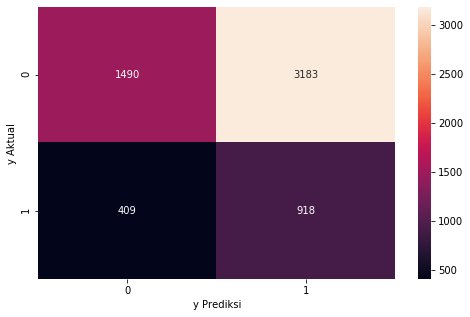

In [21]:
preprocessorrf = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), num1),
    ('categoric', cat_pipe(encoder='onehot'), cat1)
])

from sklearn.ensemble import RandomForestClassifier
pipelinerf = Pipeline([
    ('prep', preprocessorrf),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model6 = RandomizedSearchCV(pipelinerf, rsp.rf_params, cv=4,scoring='roc_auc', n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model6.fit(X_train_miss, y_train_miss)

print(model6.best_params_)
print(model6.score(X_train_miss, y_train_miss), model6.best_score_, model6.score(X1_test, y1_test))

print(classification_report(y1_test,model6.predict(X1_test)))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y1_test, model6.predict(X1_test)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Prediksi")
plt.ylabel("y Aktual")
plt.show()

Yang berbahaya dari hasil pemodelan ini adalah, jika model memprediksi 1, padahal actual nya 0, maka saya akan memilih model dengan False Positive Terkecil

Feature Importance Model RF SMOTE dengan metode mean_score_decrease

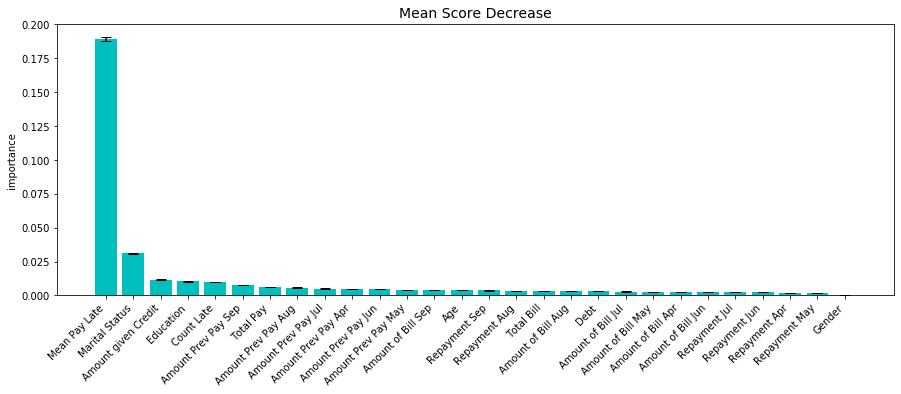

In [22]:
from jcopml.feature_importance import mean_score_decrease

imp = mean_score_decrease(X_train_res, y_train_res, model5, plot=True)

In [23]:
X_train_res

,Amount given Credit,Gender,Education,Marital Status,Age,Repayment Sep,Repayment Aug,Repayment Jul,Repayment Jun,Repayment May,...,Amount Prev Pay Aug,Amount Prev Pay Jul,Amount Prev Pay Jun,Amount Prev Pay May,Amount Prev Pay Apr,Total Bill,Total Pay,Count Late,Mean Pay Late,Debt
0,160000,2,2,2,33,2,2,3,2,0,...,0,0,6100,12300,6100,992940,39500,4,1.500000,953440
1,150000,2,1,2,34,1,0,0,0,0,...,0,0,0,0,0,53,53,1,0.166667,0
2,10000,1,2,1,50,1,2,0,0,0,...,1281,1134,294,305,1000,51461,4016,2,0.500000,47445
3,220000,2,1,2,29,0,0,0,0,0,...,9000,7887,4800,4900,6000,1117574,41687,0,0.000000,1075887
4,310000,2,1,2,32,1,0,0,0,0,...,326,0,0,0,1200,182,1526,1,0.166667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37377,140000,2,1,1,41,1,2,0,1,1,...,233,169,772,198,342,4733,1717,3,1.492363,3016
37378,50000,1,2,1,40,0,0,0,0,0,...,2945,3239,1445,722,1973,218358,12437,0,0.000000,205921
37379,108697,1,2,1,45,2,0,0,0,0,...,5558,7407,2351,2881,39039,713765,116688,1,0.478297,597077
37380,130000,1,1,1,47,0,0,0,1,0,...,1132,84,24,413,413,3562,2429,0,0.307245,1132


In [24]:
X_t = X_train_res[['Mean Pay Late','Marital Status','Education','Amount given Credit','Total Pay','Amount Prev Pay Sep',
                 'Amount Prev Pay Aug','Count Late','Amount of Bill Sep']]
# X_t = X_train_res[['Mean Pay Late','Amount given Credit','Marital Status']]
y_t = y_train_res

X_tes = X1_test[['Mean Pay Late','Marital Status','Education','Amount given Credit','Total Pay','Amount Prev Pay Sep',
                 'Amount Prev Pay Aug','Count Late','Amount of Bill Sep']]
# X_tes = X1_test[['Mean Pay Late','Amount given Credit','Marital Status']]
y_tes = y1_test

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.8min finished


{'algo__max_depth': 30, 'algo__max_features': 0.5133240027692805, 'algo__min_samples_leaf': 4, 'algo__n_estimators': 123}
0.9879299442274627 0.902328182112039 0.7447513502103104
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4673
           1       0.51      0.45      0.48      1327

    accuracy                           0.78      6000
   macro avg       0.68      0.66      0.67      6000
weighted avg       0.77      0.78      0.78      6000



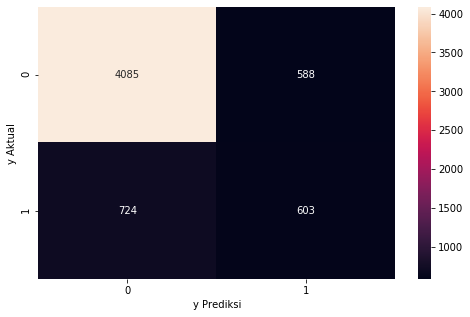

In [25]:
preprocessorrflast = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ['Mean Pay Late','Amount given Credit','Total Pay','Amount Prev Pay Sep',
                                            'Amount Prev Pay Aug','Count Late','Amount of Bill Sep']),
    ('categoric', cat_pipe(encoder='onehot'), ['Marital Status','Education'])
])

from sklearn.ensemble import RandomForestClassifier
pipelinerflast = Pipeline([
    ('prep', preprocessorrflast),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

model7 = RandomizedSearchCV(pipelinerflast, rsp.rf_params,scoring='roc_auc', cv=4, n_iter=5, n_jobs=-1, verbose=1, random_state=42)
model7.fit(X_t, y_t)

print(model7.best_params_)
print(model7.score(X_t, y_t), model7.best_score_, model7.score(X_tes, y_tes))

print(classification_report(y_tes,model7.predict(X_tes)))

f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_tes, model7.predict(X_tes)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y Prediksi")
plt.ylabel("y Aktual")
plt.show()

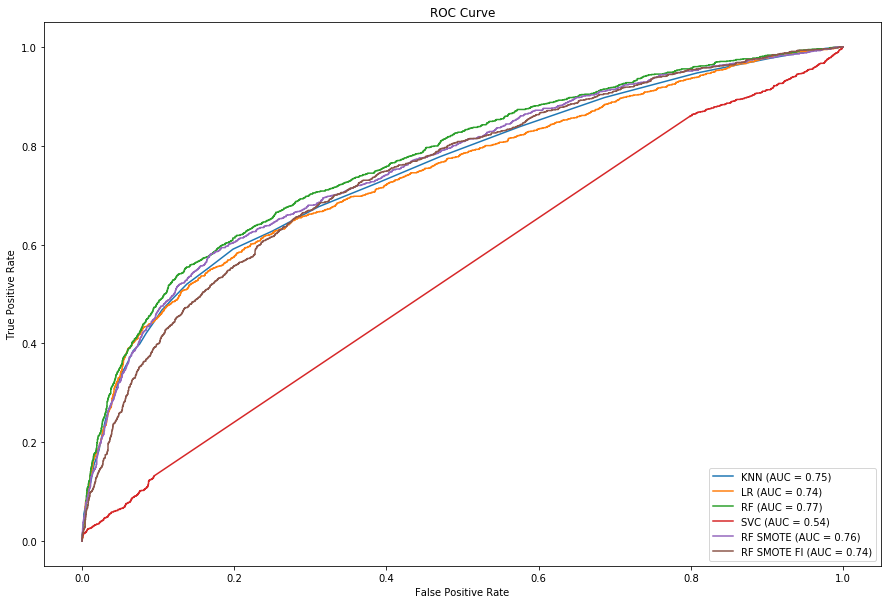

In [26]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_roc_curve, roc_auc_score, roc_curve, f1_score

plt.figure(figsize = (15,10))
ax = plt.gca()

plot_roc_curve(model1, X_test, y_test, ax=ax, name='KNN')
plot_roc_curve(model2, X_test, y_test, ax=ax, name='LR')
plot_roc_curve(model3, X_test, y_test, ax=ax, name='RF')
plot_roc_curve(model4, X_test, y_test, ax=ax, name='SVC')
plot_roc_curve(model5, X1_test, y1_test, ax=ax, name='RF SMOTE')
plot_roc_curve(model7, X_tes, y_tes, ax=ax, name='RF SMOTE FI')

plt.title('ROC Curve')
plt.show()

In [27]:
## Saya memilih model RF Smote untuk disimpan

save_model(model5.best_estimator_, "modelRFSM.pkl")
save_model(model3.best_estimator_, 'modelRF.pkl')
save_model(model7.best_estimator_, 'modelRFFI.pkl')

Model is pickled as model/modelRFSM.pkl
Model is pickled as model/modelRF.pkl
Model is pickled as model/modelRFFI.pkl
